# Predicting MIDI drum performance style

## Data preprocessing

### Utility functions

In [32]:
import pretty_midi as pm

def min_max_velocity(midi_files: list[str])-> tuple[float, float]:
    min_velocity = 1000000.0
    max_velocity = -1.0
    
    for file_name in midi_files:
        midi_data = pm.PrettyMIDI(file_name)
        velocities = [
            note.velocity 
            for note in midi_data.instruments[0].notes
        ]
        min_velocity = min(min_velocity, min(velocities))
        max_velocity = max(max_velocity, max(velocities))
    
    return min_velocity, max_velocity

In [23]:
def get_bin_names(n_bins: int) -> list[str]:
    return [
        f"bin_{i}" 
        for i in range(1, n_bins + 1)
    ]

In [33]:
def get_velocity_bins(midi_file: str,
                      min_velocity: float,
                      max_velocity: float,
                      n_bins: int) -> dict[str, float]:
    
    midi_data = pm.PrettyMIDI(midi_file)
    bins = get_bin_names(n_bins)

    result = { bin: 0.0 for bin in bins }
    bin_width = (max_velocity - min_velocity) / n_bins

    notes = midi_data.instruments[0].notes

    for note in notes:
        velocity = note.velocity
        for i in range(n_bins):
            if velocity <= min_velocity + (i+1)*bin_width:
                result[bins[i]] += 1
                break
    
    for bin in result:
        result[bin] /= len(notes)
    
    return result

### Preprocessing

In [34]:
import pandas as pd

dataset_folder = "groove-MIDI-dataset"

df = pd.read_csv(f"{dataset_folder}/info.csv")
df = df[["midi_filename", "style", "split"]]
df["style"] = df["style"].str.split("/").str.get(0)

train_df = df[df["split"] == "train"]
train_midi_files = [
    f"{dataset_folder}/{file_name}" 
    for file_name in train_df["midi_filename"]
]

min_velocity, max_velocity = min_max_velocity(train_midi_files)
n_bins = 10

def create_velocity_bins(row):
    midi_file = f"{dataset_folder}/{row['midi_filename']}"

    return pd.Series(get_velocity_bins(
        midi_file, min_velocity, max_velocity, n_bins
    ))

bin_cols = df.apply(create_velocity_bins, axis=1)
df = pd.concat([df, bin_cols], axis=1)

df.head()

,midi_filename,style,split,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10
0,drummer1/eval_session/1_funk-groove1_138_beat_...,funk,test,0.002439,0.046341,0.163415,0.263415,0.204878,0.109756,0.104878,0.051220,0.039024,0.014634
1,drummer1/eval_session/10_soul-groove10_102_bea...,soul,test,0.076923,0.040486,0.024291,0.085020,0.149798,0.153846,0.141700,0.072874,0.072874,0.182186
2,drummer1/eval_session/2_funk-groove2_105_beat_...,funk,test,0.037152,0.074303,0.099071,0.123839,0.188854,0.142415,0.133127,0.055728,0.065015,0.080495
3,drummer1/eval_session/3_soul-groove3_86_beat_4...,soul,test,0.043764,0.155361,0.407002,0.170678,0.142232,0.010941,0.017505,0.035011,0.010941,0.006565
4,drummer1/eval_session/4_soul-groove4_80_beat_4...,soul,test,0.004484,0.008969,0.035874,0.094170,0.156951,0.215247,0.152466,0.143498,0.130045,0.058296


### Train/validation/test split

In [35]:
bin_names = get_bin_names(n_bins)

train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "validation"]
test_df = df[df["split"] == "test"]

train_X = train_df[bin_names]
train_Y = train_df["style"]

val_X = val_df[bin_names]
val_Y = val_df["style"]

test_X = test_df[bin_names]
test_Y = test_df["style"]

## Training

Train different classifier models and plot confusion matrix based on validation dataset. Each row of the confusion matrix is normalized.

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


def plot_confusion_matrix(classifier):
    label_enc = LabelEncoder()
    enc_train_Y = label_enc.fit_transform(train_Y)
    enc_val_Y = label_enc.transform(val_Y)

    trained_clf = classifier.fit(train_X, enc_train_Y)
    
    ConfusionMatrixDisplay.from_estimator(
        estimator=trained_clf,
        X = val_X,
        y = enc_val_Y,
        normalize = "true",
        cmap = "magma",
        include_values = False,
        labels = trained_clf.classes_,
        display_labels=label_enc.classes_,
        xticks_rotation = "vertical"
    )

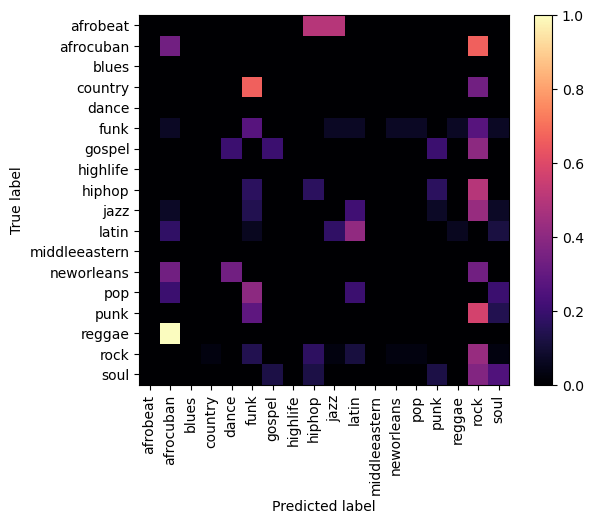

In [51]:
from sklearn.tree import DecisionTreeClassifier

plot_confusion_matrix(DecisionTreeClassifier())

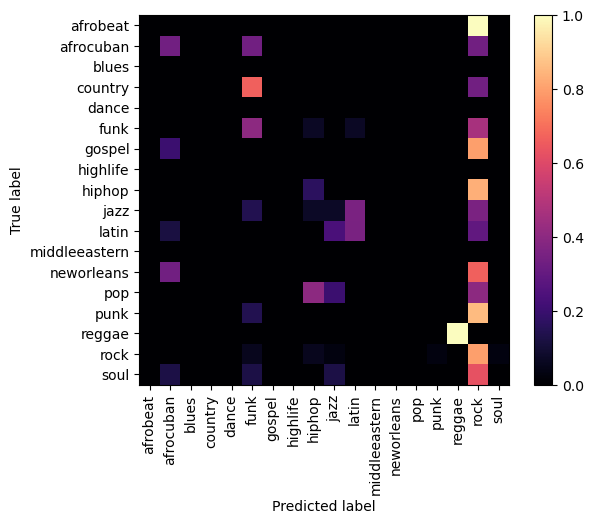

In [52]:
from sklearn.ensemble import RandomForestClassifier

plot_confusion_matrix(RandomForestClassifier())

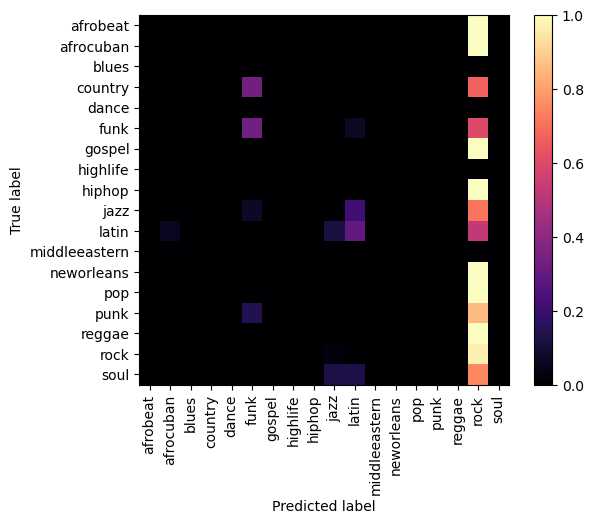

In [53]:
from sklearn.svm import SVC

plot_confusion_matrix(SVC())

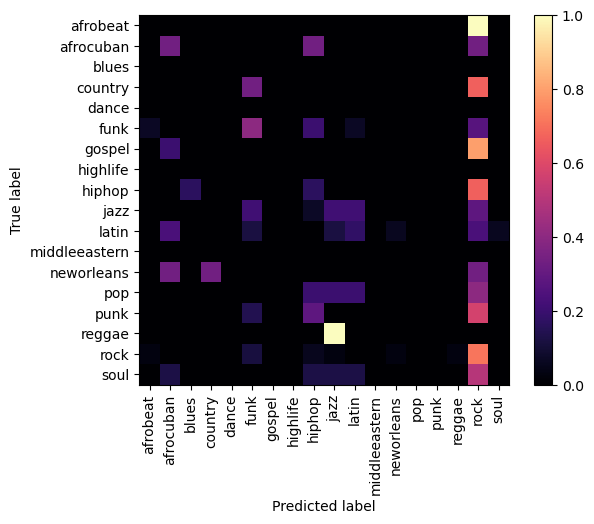

In [54]:
from sklearn.neighbors import KNeighborsClassifier

plot_confusion_matrix(KNeighborsClassifier())